# Performance of LSH for coreferences

In [1]:
from load_coreferences import load_coreferences, load_pairs
# import lsh 
from REL import lsh 
import copy
import numpy as np
import time 
import matplotlib.pyplot as plt

import cProfile

scaling_factor = 5 # multiply size the original data set by this factor

In [2]:
all_pairs = load_pairs()
raw_mentions = load_coreferences()
mentions = {i: m for i, m in enumerate(raw_mentions)}


#### Effectiveness

In [3]:
def evaluate_coref_predictions(pairs_gold, candidates, _return = False):
    "Precision and recall for LSH coref pair search"
    missed = 0 
    correct = 0 
    wrong = 0

    for mention, true_reference in pairs_gold.items():
        current_candidates = candidates[mention]

        if true_reference not in current_candidates:
            missed += 1
        for candidate in current_candidates:
            if candidate == true_reference:
                correct += 1
            elif candidate != true_reference:
                wrong += 1


    precision = correct / (correct + wrong)
    recall = correct / (correct + missed)

    ndig = 3
    if not _return:
        print(f"Precision: {round(precision, ndig)}") # note: lower precision means larger comparison set for coref classification.
        print(f"Recall: {round(recall, ndig)}") 
    else:
        return (precision, recall)

In [4]:
pairs_gold = {}
for pair_doc in all_pairs.values():
    for p in pair_doc:
        pairs_gold[p[1]] = p[0] # key = mention, value = true coreference



Make signature with a while loop 

In [9]:
mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=2, signature_size=800, band_length=10) # shingle size 2, signature size 800, band length 10

mylsh.cluster(candidates="new")
mylsh.summarise()
candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]] for idx, mention in mentions.items()}

evaluate_coref_predictions(pairs_gold, candidates)



no limit 
-------
took 0.027411460876464844 seconds for 174 mentions
average, min, max cluster size: 25.57, 8, 47
Precision: 0.038
Recall: 0.966


Properties    
- longer signature $\rightarrow$ higher recall, lower precision
- larger shingle $\rightarrow$ lower recall, higher precision
- longer band $\rightarrow$ lower recall, higher precision


In [10]:

# old approach 
max_signature_size = 1500
min_signature_size = 100
# band_lengths = [2, 3, 4] # varying band lengths gives not strictly increasing ROC curve
band_lengths = [15]
shingle_sizes = [2,3,4]

measure_dict = {}

for shingle_size in shingle_sizes:
    l = band_lengths[0]
    measurements = []
    start_size = min_signature_size - (min_signature_size % l) + l # start at next multiple of l
    for s in range(start_size, max_signature_size, l):
        mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=shingle_size, signature_size=s, band_length=l)

        mylsh.cluster()
        candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

        m = evaluate_coref_predictions(pairs_gold, candidates, _return=True)
        out = m + (s,)
        measurements.append(out)
    measure_dict[shingle_size] = measurements


In [22]:

# old approach 
max_signature_size = 2000
min_signature_size = 20
# band_lengths = [2, 3, 4] # varying band lengths gives not strictly increasing ROC curve
band_lengths = [15]
shingle_sizes = [2,3,4]

measure_dict = {}

for shingle_size in shingle_sizes:
    l = band_lengths[0]
    measurements = []
    start_size = min_signature_size - (min_signature_size % l) + l # start at next multiple of l
    for s in range(start_size, max_signature_size, 4*l):
        mylsh = lsh.LSHMinHash(mentions=mentions, shingle_size=shingle_size, signature_size=s, band_length=l)

        mylsh.cluster(candidates="new")
        candidates = {mention: [mentions[i] for i in mylsh.candidates[idx]]  for idx, mention in mentions.items()}

        m = evaluate_coref_predictions(pairs_gold, candidates, _return=True)
        out = m + (s,)
        measurements.append(out)
    measure_dict[shingle_size] = measurements

In [23]:
md = {k: [
    [1 - i[0] for i in measures], # fpr
    [i[1] for i in measures], # recall,
    [i[2] for i in measures] # signature size
] for k, measures in measure_dict.items()}


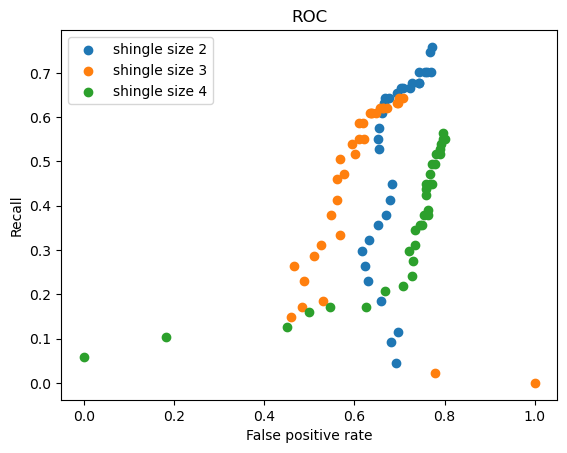

In [24]:
fig, ax = plt.subplots()
for k, v in md.items():
    lbl = f"shingle size {k}"
    ax.scatter(x=v[0], y=v[1], label=lbl)

ax.set_xlabel("False positive rate")
ax.set_ylabel("Recall")
ax.set_title("ROC")
ax.legend()

/tmp/ipykernel_5785/2962560467.py:5: RuntimeWarning: invalid value encountered in divide
  fscore = 2 * precision * recall / (precision + recall)


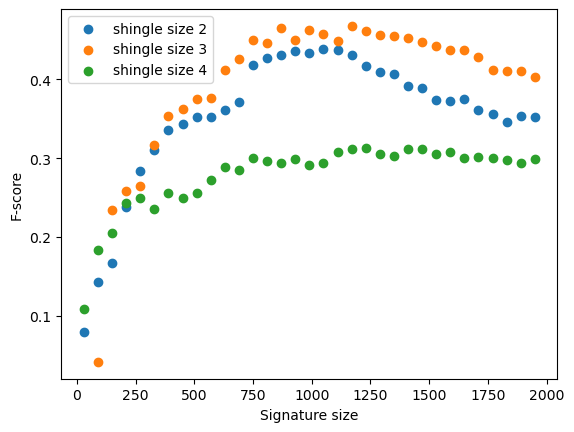

In [25]:
fig, ax = plt.subplots()
for k, v in md.items():
    precision = np.array([1-i for i in v[0]])
    recall = np.array([i for i in v[1]])
    fscore = 2 * precision * recall / (precision + recall)
    lbl = f"shingle size {k}"
    ax.scatter(y=fscore, x=v[2], label=lbl)

ax.set_ylabel("F-score")
ax.set_xlabel("Signature size")
ax.legend()

Notes 
- trade off: get the same recall for smaller false positive rate with larger shingle size, but need a larger signature and thus more time 
    - improve the calculation of the signature?
    - another benefit however is that with a smaller false positive rate, the `with_coref` call in REL will be faster (smaller comparison sets)
    - also important: higher false positive rate means more comparisons also for those mentions that are *not* coreferences (and are not in the present dataset).
    - check again the time complexity of this -- signature length of 300 may not be feasible/lead to long computing time when data set is a few thousands of mentions
- add color shading for shingle size? --
- the can look like they have a negative slope (particularly for shingle size 4). Not sure why. Also happened when I varied the band lengths. does it have to do with the ordering of the input to the plot? 

#### Profiling

In [29]:

# stack mentions on top of each other 
mentions_scaled = copy.copy(mentions)

idx = len(mentions_scaled)
for i in range(1, scaling_factor):
    for idx_old in mentions.keys():
        m = mentions[idx_old]
        mentions_scaled[idx] = m 
        idx += 1

## some tests to be put to REL. see the lsh.py class for the function definition. 

test for `cols_to_int` (?). need to check the details; not sure anymore this remains relevant. it is for sorting multidimensional array along one axis

In [6]:
x = np.array([[0, 3], [2, 2], [2, 2], [0, 3]]) 
x = np.array([[1, 3], [2, 2], [2, 2], [1, 3], [1, 5], [1, 1]]) # this is one test case
A = np.array([[3,4], [3,5], [5,6], [3,4], [6,7]]) # this is another test case

display(A)
display(np.argsort(A, axis=0))
display(A.view('i8,i8').argsort(order=['f1'], axis=0))

display(x)
display(np.argsort(x, axis=0))
display(x.view('i8,i8').argsort(order=['f1'], axis=0))


array([[3, 4],
       [3, 5],
       [5, 6],
       [3, 4],
       [6, 7]])

array([[0, 0],
       [1, 3],
       [3, 1],
       [2, 2],
       [4, 4]])

array([[0],
       [3],
       [1],
       [2],
       [4]])

array([[1, 3],
       [2, 2],
       [2, 2],
       [1, 3],
       [1, 5],
       [1, 1]])

array([[0, 5],
       [3, 1],
       [4, 2],
       [5, 0],
       [1, 3],
       [2, 4]])

array([[5],
       [1],
       [2],
       [0],
       [3],
       [4]])

test for `vectorize_signature_bands`

In [312]:
## test 
a = np.array([[1, 4, 7, 8, 10, 8], [5, 3, 2, 6, 11, 0], [1, 4, 2, 6, 13, 15]])

n_bands = 2
n_items = a.shape[0]
band_length = int(a.shape[1]/n_bands)
result = vectorize_signature_bands(a, n_bands=n_bands, band_length=band_length)

expected = np.vstack(np.split(a, n_bands, axis=1)).reshape(n_bands, n_items, -1)

assert np.all(result == expected), "signature bands not vectorized correctly"



test for `group_unique_indices`. 

In [504]:
a = np.array([[1, 4, 7, 8], [1, 4, 2, 7], [5, 3, 2, 6]])
n_bands = 2
n_items = a.shape[0]
band_length = int(a.shape[1]/n_bands)
a = vectorize_signature_bands(a, n_bands=n_bands, band_length=band_length)

# print("a before cols_to_int:")
display(a)
# print("after:")
# a = cols_to_int_multidim(a)
display(a)
a = group_unique_indices(a)
a

array([[[1, 4],
        [1, 4],
        [5, 3]],

       [[7, 8],
        [2, 7],
        [2, 6]]])

array([[[1, 4],
        [1, 4],
        [5, 3]],

       [[7, 8],
        [2, 7],
        [2, 6]]])

[[array([0, 1]), array([2])], [array([2]), array([1]), array([0])]]